# Import

!pip install numpy
!pip install pandas
!pip install nltk
!pip install tqdm
!pip install gensim
!pip install spacy
!pip install scikit-learn
!pip install matplotlib
!python -m spacy download en_core_web_lg

In [28]:
import numpy as np
import pandas as pd
import nltk
import tqdm
from nltk.corpus import stopwords
import re,string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import gc
import gensim
import collections
nlp = spacy.load('en_core_web_lg')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 500

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
# фиксирую рэндом сид чтобы эксперименты были воспроизводимы
np.random.seed(31415)

# Data

df = pd.read_excel('data/vr_ar_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
out_path='data/vr_ar_classification_output.xlsx'

df = pd.read_excel('data/besprovodnaya_svyaz__0_95_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())

df = pd.read_excel('data/besprovodnaya_svyaz_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

In [30]:
df = pd.read_excel('data/neur_ai_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())
#7041 unic words
out_path='data/neur_ai_classification_output.xlsx'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25876 entries, 0 to 25877
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  25876 non-null  string
dtypes: string(1)
memory usage: 404.3 KB
None


df = pd.read_excel('data/new_technologies_classification.xlsx')
#df=df.drop(columns=['area1','area2','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/quants_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/rasp_reestr_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/robo_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

# Preprocessing

In [31]:
gc.collect()
# переводим в нижний регистр, удаляем пунктуацию и цифры, заменяем знаки доллара и евро на слова. 
# удаляются двойные пробелы
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text= re.sub(r'%', ' percent ', text)
    text=re.sub('\$', ' dollar ', text)
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub('\s+', ' ', text)  
    return text

In [32]:
# список неинформативных коротки слов которые раньше были аббревиатурой 
# или частным названием. осмысленные не включал bad', 'bag', 'bal', 'box', 'bug'
not_informative_short_words =['aaa', 'acc', 'abi', 'add', 'adt', 'aec', 'afp', 'ana', 'aol', 'apr', 'arc', 'ars', 'ash', 'atm',
                              'aud', 
                              'aug', 'avr', 'awp', 'bay', 'bbm', 'bcc', 'bci', 'ben', 'ble', 'bmi', 'boo', 'cad', 'cap', 'cbs', 
                              'ccd', 'ccp', 'ccs', 'cds', 'cee', 'ces', 'cfo', 'cgi', 'cis', 'cld', 'cns', 'cny', 'cpa', 'cta', 
                              'cto', 'cub', 'cup', 'daf', 'dan', 'daz', 'dci', 'ddr', 'dev', 'dew', 'dfc', 'dgx', 'dip', 'dlc', 
                              'dpb', 'dpi', 'dre', 'eap', 'ebt', 'eco', 'edr', 'eli', 'ems', 'eon', 'eos', 'epa', 'era', 'esa', 
                              'esi', 'etc', 'etf', 'evo', 'faa', 'fab', 'fax', 'fda', 'fed', 'fee', 'fig', 'fis', 'fla', 'fov', 
                              'gag', 'gcg', 'gdp', 'gfk', 'ghz', 'gic', 'glu', 'gos', 'gsm', 'gta', 'gtc', 'gtg', 'gtx', 'hai', 
                              'hbo', 'hed', 'hes', 'hfr', 'hlm', 'hlp', 'hmd', 'hmi', 'hon', 'htv', 'hub', 'hud', 'iab', 'iae', 
                              'ian', 'iap', 'ibd', 'ibm', 'ics', 'idc', 'idg', 'ifa', 'ign', 'igt', 'ihs', 'iii', 'imu', 'inc', 
                              'ind', 'int', 'ion', 'iot', 'ips', 'ise', 'isp', 'iss', 'ive', 'iyl', 'jio', 'jmi', 'jon', 'jun', 
                              'jwn', 'khz', 'kit', 'kwh', 'lab', 'lap', 'las', 'lbe', 'lcd', 'led', 'lgs', 'liu', 'low', 'lpm', 
                              'lrn', 'ltd', 'lte', 'lti', 'lux', 'mah', 'met', 'mhl', 'mid', 'mlg', 'mmo', 'mpg', 'mph', 'mrc', 
                              'mri', 'msc', 'msm', 'msv', 'nab', 'nba', 'nbc', 'nea', 'nfl', 'ngr', 'nov', 'nox', 'npd', 'nsf', 
                              'nsn', 'ntt', 'nuc', 'nzd', 'oak', 'oct', 'odv', 'oem', 'ohm', 'ooh', 'opi', 'opt', 'ore', 'org', 
                              'owc', 'par', 'pbr', 'pci', 'pcs', 'pct', 'phd', 'pic', 'plc', 'ppb', 'ppd', 'ppi', 'ppm', 'pre', 
                              'prn', 'pwc', 'qct', 'qqq', 'qsi', 'qtl', 'rec', 'rig', 'rim', 'rmb', 'roy', 'rpm', 'rtx', 'rue', 
                              'sad', 'sam', 'sas', 'sci', 'sek', 'shp', 'skf', 'sne', 'soc', 'spx', 'sqm', 'srp', 'stx', 'sub', 
                              'swp', 'tap', 'tcl', 'tel', 'tfe', 'thd', 'tim', 'tmr', 'tri', 'tvs', 'uav', 'ubi', 'uhd', 'uks', 
                              'usc', 'utm', 'uva', 'uvb', 'vcs', 'vfr', 'vic', 'von', 'vrd', 'vrs', 'vrx', 'wen', 'wii', 'win', 
                              'wow', 'wwe', 'wwf', 'xie', 'xlk', 'yaw', 'yoy', 'zhu', 'zvi',
                              'aal', 'aap', 'abb', 'abd', 'abp','abu', 'aci', 'acm', 'act', 'ada', 'adi', 'adl', 'adn', 'adr', 
                              'ads', 'aed', 'aeg', 'aep', 'aer', 'afr', 'agg', 'agm', 'agr', 'aha', 'ahs', 'aid', 'aii','ais',
                              'aka', 'ala', 'ali', 'alp', 'als', 'amc', 'ami', 'amn', 'amp', 'amr', 'amt', 'and', 'ant', 'anz',
                              'aok', 'api', 'app', 'aps', 'ari', 'asp', 'asu', 'asx', 'atc', 'ate', 'ati', 'atl', 'atp', 'att',
                              'atw', 'awd', 'aws', 'bac','bbb', 'bbc', 'bbk', 'bcd', 'bce', 'bch', 'bcs', 'bdt', 'beh', 'bet', 
                              'bhp', 'bia', 'bid', 'bif', 'big', 'bin', 'bip', 'bit', 'bli', 'bln', 'blu', 'bmo', 'bms', 'bmw',
                              'bns', 'bpd', 'bpi', 'bpo', 'bps', 'brl', 'bse', 'bss', 'btc', 'bts', 'btu', 'buf', 'bui','bwa', 
                              'byo', 'cae', 'caf', 'cak', 'cbp', 'ccg', 'cch', 'cci', 'ccl', 'cdc', 'cdn', 'cea', 'cem','cfe',
                              'cfs', 'cfu', 'cfx', 'cgo', 'cha', 'chd', 'chf', 'chi', 'chl', 'cho', 'chu', 'cia', 'cin', 'cio',
                              'cit', 'ckd', 'cle', 'clp',  'cmk', 'cmo', 'cmr', 'cms', 'cmt', 'cnb', 'cnc', 'cng', 'cnw', 'com',
                              'con', 'coo','co₂', 'cpc', 'cpe', 'cph', 'cpi', 'cps','cpv', 'cpw', 'crm', 'cry', 'cse', 'csl', 
                              'csm', 'csp', 'csr', 'css', 'cus', 'cut', 'cvc', 'cvg', 'cyn', 'czk', 'dab', 'dal', 'dam', 'das',
                              'dax',  'dbs', 'dcg', 'dcm', 'dda', 'ddh', 'ddt', 'dec', 'del', 'den', 'der', 'des', 'det', 'dft',
                              'dha', 'dhl', 'dhq', 'dig', 'div', 'diy', 'djb', 'dld', 'dlr', 'dmi', 'dmr', 'dna', 'dng', 'doe',
                              'dou', 'dow', 'dsc', 'dsl', 'dso', 'dsp', 'dtc', 'dth', 'dtl', 'dts', 'dtw', 'due', 'dug', 'duo',
                              'dvb',  'dvr', 'dxb', 'eas','ebs', 'eda', 'edm', 'edt', 'eee', 'ees', 'efb', 'egp', 'ehr', 'ehs',
                              'eia', 'eid', 'eir', 'emc', 'emd', 'emi', 'emt', 'emv', 'end', 'eno', 'ent', 'epc', 'epi',  'eqb',
                              'erc', 'ers', 'eso', 'est', 'etb', 'etd', 'ett', 'eur', 'eus', 'evf', 'evm', 'evs', 'ewj', 'ews',
                              'eye', 'fao', 'fat', 'fba', 'fca', 'fcc', 'fcf', 'fci', 'fcs', 'fdi', 'fdn', 'feb', 'fgw','flo',
                              'fly', 'fmc', 'fmi', 'fni', 'fon','fsa', 'fsi', 'fss', 'fst', 'ftc', 'ftr', 'fun', 'fwa', 'fxi', 
                              'gaa', 'gal', 'gan', 'gao', 'gba', 'gbe', 'gby', 'gcf', 'gee', 'gen', 'ges', 'get', 'gfg', 'ggv',
                              'ghg', 'ghs', 'gif', 'gig', 'giv', 'gla', 'gmt', 'gmv', 'gni', 'gnw', 'gpv', 'grm', 'gru', 'gsa',
                              'gsi', 'gsk', 'gst', 'gth', 'gtm', 'gto', 'gun', 'guo', 'gut', 'gva', 'gvt', 'gwe', 'gwh', 'gør',
                              'han', 'har', 'hat', 'hba', 'hbb', 'hcc', 'hcl', 'hdb', 'hdd', 'hdi', 'hdr', 'hdx', 'hem', 'hev', 
                              'hex', 'hey', 'hfc', 'hia', 'hip', 'hit','hkd', 'hkx', 'hlr', 'hns', 'hos', 'hou', 'hpc', 'hpe',
                              'hpj', 'hps', 'hrb', 'hrs', 'htc', 'hts', 'htt', 'hua', 'høy', 'iac', 'ibs', 'ibw', 'ica', 'icn',
                              'icp', 'ict', 'ida', 'idf', 'idh', 'idp', 'idx', 'ied', 'iee', 'ift', 'igr', 'igv', 'iia', 'iin', 'ijj',
                              'ill', 'imf', 'img', 'imo', 'ims', 'ina', 'ing', 'ink', 'inn', 'inr', 'ins', 'ioc', 'ioe', 'ios', 'ipc',
                              'ipd', 'ipo', 'ipr', 'ipv', 'ipx', 'iri', 'irs', 'isi', 'ism', 'itc', 'itm', 'itu', 'itv', 'iuc', 'iwd',
                              'iwf', 'iwr', 'iyt', 'izy', 'jam', 'jan', 'jet', 'jfk', 'jgp', 'jim', 'job', 'jpr', 'jpy', 'jqh', 'jsc',
                              'jui', 'jul', 'kan', 'kfc', 'kgi', 'kgs', 'kid', 'kik', 'kim', 'kkr', 'kla', 'klm', 'kmi', 'kms', 'km²',
                              'koa', 'kph', 'kpn', 'krw', 'kse', 'kts', 'kun', 'kuo', 'kva', 'kvh', 'kwd', 'laa', 'lag', 'lam', 'lan',
                              'lat', 'law', 'lay', 'lbs', 'lcc', 'lce', 'lco', 'lda', 'ldc', 'lee', 'les', 'let', 'lex', 'lgb', 'lie',
                              'lis', 'lla', 'llc', 'lmc', 'lmr', 'lng', 'log', 'loi', 'lok', 'los', 'lot', 'lpg', 'lps', 'lrs', 'lse', 
                              'lsi', 'lsp', 'lsr', 'ltm', 'lui', 'luk', 'lum', 'luo', 'lyf', 'lzo', 'lzt', 'mab',  'mag', 'man',
                              'map', 'mar', 'mat', 'mau','mbb', 'mbs', 'mbu', 'mca', 'mcd', 'mcm', 'mco', 'mdd', 'mdg', 'mdm', 'mdr', 'mea',
                              'med', 'mee', 'mem',  'meq', 'mfi', 'mhi', 'mhs', 'mhz', 'mic', 'mik', 'mil', 'mim',  'mio', 'mir', 'mis',
                              'mit', 'mix', 'mjn', 'mln', 'mms', 'mmt', 'mnf', 'mno', 'mnp', 'mod', 'mog', 'mom', 'mos', 'mou', 'moz',    
                              'mpa', 'mpc', 'mpd', 'mps', 'mrm', 'mro', 'mrp', 'msa', 'msi', 'msn', 'mss', 'mst', 'mtg', 'mtl', 'mtn', 'mts',
                              'mvp', 'mwc', 'mwh', 'máv', 'nas', 'nbn', 'ncr', 'nec', 'net', 'new', 'nfc', 'nff', 'nfv', 'ngh', 'nhk', 'nhn',
                              'nhs', 'nis', 'nok', 'non', 'npt', 'nre', 'nrf', 'nrg', 'nse', 'nsl', 'nsr', 'nsw', 'ntc', 'ntd', 'ntf', 
                              'ntp', 'ntv', 'nwe', 'nws', 'nxp', 'nxt', 'nyg', 'nyj', 'obd', 'obr', 'obs', 'ocf', 'och', 'ocs', 'odd',
                              'odm', 'oee', 'oes', 'ohb', 'oie', 'oil', 'old', 'one', 'ono', 'ons', 'ont', 'orc', 'oro', 'orr', 'osa',
                              'osk', 'ota', 'otc', 'ott', 'owe', 'oza', 'pac', 'pad', 'pan','pbs', 'pbx', 'pcb', 'pch', 'pcl', 'pcp',
                              'pds', 'pdv', 'peg', 'per', 'pet', 'pew', 'pgh', 'phe', 'phl', 'pie', 'pig', 'pin', 'pit', 'pkr', 'pla',
                              'pld', 'plm', 'pls', 'ply', 'pme', 'pnb', 'pod', 'pop', 'pos', 'pot', 'ppg', 'ppp', 'pps', 'ppv', 'prc',
                              'pro', 'prp', 'psg', 'psi', 'psy', 'pta', 'ptp', 'pts', 'pub', 'put', 'pvc', 'pyg', 'qad', 'qar',
                              'qcc', 'qfy', 'qhd', 'qnx', 'qoq', 'qvc', 'rac', 'raj', 'ram', 'ran', 'raw', 'ray', 'rba', 'rbc',
                              'rbi', 'rca', 'rcr', 'rcs', 'rda', 'rdd', 'red', 'ree', 'ren', 'rev', 'rex', 'rey', 'rgb', 'rgu', 
                              'rhi', 'rid', 'ril', 'rio', 'rkg', 'rmg', 'rmi', 'rmr', 'roa', 'roc', 'rod', 'roe', 'rog', 'roi',
                              'rom', 'ron', 'rov','rrb', 'rrh', 'rsa', 'rse', 'rsi', 'rtk', 'rub', 'run', 'rwc', 'saf', 'san',
                              'sao', 'sap', 'sar', 'sat','sba', 'sbc', 'sbi', 'sbo', 'sce', 'scs', 'sdg', 'sdn',
                              'sea', 'sec', 'see', 'sel', 'sen', 'sep', 'ses', 'set', 'sex', 'sfr', 'sgt', 'sgx', 'shy', 
                              'sia', 'sim', 'sis', 'sit', 'siy', 'ski', 'skm', 'skt', 'sky', 'slp', 'smb', 'sme', 'smg',
                              'smh', 'smk', 'smp', 'sms', 'smt', 'sns', 'soi', 'sol', 'som', 'son', 'sot', 'soy', 'spg',
                              'sph', 'spi', 'spy', 'sri', 'ssa', 'ssd', 'sse', 'ssl', 'ssm', 'std', 'stl', 'stp', 'sts',
                              'stv', 'suc', 'sud', 'sui', 'sum', 'sun', 'sur', 'suv', 'svp', 'svw', 'tab', 'tac', 'tad',
                              'tag', 'tal', 'tam', 'tan', 'tas',  'tbr', 'tbs', 'tcf', 'tcm', 'tco', 'tcs', 'tdd',
                              'tdi', 'tdk', 'tec', 'tek',  'ter', 'tex', 'tfa', 'tft', 'the', 'thz', 'tie', 'til', 
                              'tio', 'tip', 'tis', 'tls', 'tms', 'tom', 'ton', 'tpg', 'tpv', 'tpy', 'tre', 'try', 
                              'tsa', 'tse', 'tsr', 'tuc', 'tvb', 'tvc', 'twc', 'twh', 'two', 'txn', 'uae', 'uah', 
                              'ual', 'ubm', 'ubs', 'ucs', 'ufs', 'uhf', 'uhs', 'ulm', 'umc', 'und', 'une', 'upc', 
                              'upi', 'upm', 'ups', 'uqc', 'ure', 'usa', 'usb', 'usd', 'use', 'usf', 'uss', 'usv', 
                              'val', 'van', 'var', 'vas', 'vat', 'vdc', 'vdd', 'ver', 'vfc', 'vha', 'vhf', 'via',
                              'vil', 'vis', 'vnf', 'vni', 'voc', 'vod', 'vpn', 'vrf', 'vtr', 'vzw', 'wal', 'wan',
                              'wap', 'war', 'wav', 'wba', 'web', 'wed', 'wes', 'wet', 'wls', 'wos', 'wpc'
                              , 'wsj', 'wsn', 'wtg', 'www', 'xad', 'xfi', 'xia', 'xin', 'xlv', 'xmi', 'xps', 'xrp',
                              'xue', 'xzz', 'yds', 'yea', 'yen', 'yep','yfm', 'yin', 'ysa', 'ytd', 'yum', 'yun', 'zal',
                              'zee', 'zem', 'zte', 'zto',
                             'aao','abt', 'aca', 'acd', 'ach', 'ack', 'acl', 'acn', 'aco', 'acr', 'acs', 'acv', 'adb', 'adj', 'ado', 
                              'adp','aes', 'aet', 'afl', 'agc', 'agh', 'agi', 'agn','ags', 'agv', 'ahn', 'ahu', 'aig', 'alm', 'alt', 'ama',
                              'ame', 'aml', 'ams', 'amv', 'amy', 'anc','ann', 'aoc', 'aog', 'aon', 'aov', 'apa', 'apd', 'apl', 'apm', 'aqr',
                              'arr','asa', 'asc', 'asd', 'asm', 'asr', 'ata', 'atd', 'ato', 'auf', 'aum','avx', 'awe', 'axa', 'ayx', 'baa',
                              'bam', 'ban', 'bao', 'bar', 'bax', 'bba', 'bbl', 'bca', 'bcf', 'bcm', 'bct', 'bda', 'bdc',
                              'bdo', 'bds', 'bec','bep', 'bgc', 'bgf', 'bgr', 'bhi', 'bim', 'bio', 'bis', 'biu', 'biz', 'bjh', 'bjp',
                              'bjs', 'bkc', 'bkw', 'bls', 'bmc', 'bnp', 'bob', 'boe', 'bol','bpl', 'bpm', 'bpt', 'bra', 'bsa', 'bsi', 'bsv',
                              'bsx', 'bti', 'btl', 'bto', 'btw', 'bud', 'buz', 'bwc', 'cab', 'cac', 'cba', 'cbd', 'cbi', 'cbm', 'cca', 'ccb', 
                              'ccc', 'ccm', 'ccr', 'cdg', 'cdi', 'cdk', 'cdo', 'cdw', 'cdx', 'ceb', 'cec', 'cef', 'cel', 'cep', 'cet', 'cgm',
                              'cgn', 'che', 'cic', 'cke', 'cli', 'cma', 'cme', 'cmf', 'cmi', 'cml', 'cmu', 'cnk', 'cnn', 'cnt', 'cod', 'col',
                              'cor', 'cos','cpg', 'cpm', 'cpo', 'cpp', 'cpr', 'cpt', 'cpu', 'crc', 'cro', 'crv', 'csa', 'csd', 'csf', 'csi',
                              'cso', 'ctd', 'cti', 'ctr', 'cue', 'cuh', 'cvd', 'cvs', 'cwc', 'cxa', 'cxu', 'cys', 'dag', 'dai', 'dao', 'dau',
                              'dbr', 'dcc', 'dco', 'dcp', 'dds', 'dee', 'dei', 'dem', 'dfj', 'dfm', 'dhe', 'dia', 'dif', 'dik', 'dim', 'dkk', 
                              'dkr', 'dlp', 'dls', 'dmc', 'dme', 'dmf', 'dmg', 'dms', 'dnb', 'dnf', 'dno', 'doa', 'doc', 'dod', 'doi', 'doj',
                              'dos', 'dpm', 'dpu', 'drg', 'dss', 'dte', 'dtm', 'dto', 'dtt', 'dun', 'dup', 'dut','dvm', 'dvt', 'dxl', 'dye',
                              'eab', 'eam','ecj', 'ecm', 'ecs', 'edf', 'edp', 'eds', 'edu', 'eeg', 'eff', 'efm', 'egg', 'egm', 'ein', 'eiu',
                              'ekg', 'eld', 'elf', 'ema', 'emr', 'eps', 'erm', 'erp', 'erx', 'esd', 'esn', 'esp', 'eth', 'etl', 'eva', 'exa',
                              'ext', 'eys', 'faf','faq', 'far', 'fay', 'fbi', 'fbr', 'fdp', 'fep', 'fet', 'fft', 'fia', 'fin', 'fkf', 'fld',
                              'flg', 'flu', 'fos', 'fou','fpc', 'fpl', 'fps', 'frr', 'frs', 'fse', 'fsr', 'fte', 'ftk', 'ft³', 'fup', 'fyp',
                              'gac','gbi', 'gbp', 'gbs', 'gca', 'gcc', 'gel','ggr', 'ghk', 'gii', 'gle', 'glj', 'gma', 'gms', 'goa','gox', 'gpa',
                              'grc', 'grp', 'gsr', 'gsu', 'gsv', 'guy', 'gvc', 'gwp','hal', 'hbl', 'hbs', 'hci', 'hcm', 'hcq', 'hcs', 'hdl', 'hdp',
                              'hfn', 'hfo', 'hfs', 'hft', 'hhs', 'hie', 'hiv', 'hla', 'hmh', 'hmq', 'hmx', 'hny', 'hoc', 'hot', 'hrc', 'hrd', 'hsn',
                              'htf', 'htm', 'hue', 'hut', 'hvc', 'hya', 'hzb', 'hzi', 'ias', 'ibc', 'ibn', 'ibo', 'icc', 'icd','icf', 'ico', 'icu',
                              'icy', 'idm', 'ids', 'idw', 'ieg', 'ieo', 'ifr', 'ifs', 'ifx', 'igd', 'igm', 'ihc', 'ihl', 'iis', 'ijb', 'ile', 'ime',
                              'ini', 'inv', 'iod', 'iou', 'ipa', 'ipf', 'ipu', 'iqe', 'iqf', 'irc', 'ird', 'irr', 'isc', 'isg', 'ish', 'iso', 'ist',
                              'ito', 'iva', 'ivc', 'ivf', 'ivp', 'ivr', 'ivv', 'ivy', 'iwg', 'iwv', 'ixc', 'iyk', 'iyw', 'jaw', 'jda', 'jek', 'jft',
                              'jha', 'jhu', 'jit', 'jll', 'joe', 'jog', 'joy', 'jpl', 'kai', 'kar', 'kbr', 'ken','kia', 'koc', 'koh', 'kpa', 'kyc',
                              'lal', 'lau', 'lbp', 'lcs', 'ldl', 'len', 'leo', 'lev', 'lfw', 'lgp', 'lib', 'lip', 'lit', 'liv', 'liz', 'llp', 'lns',
                              'lol', 'lpd', 'lpo', 'lpt', 'ltl', 'ltv', 'luc', 'luz', 'léo','mba', 'mcg', 'mch', 'mcp', 'mcu', 'mcx', 'mdt', 'meg',
                              'mes', 'mfp', 'mgi', 'mgm', 'mig', 'min', 'mlb', 'mld', 'mmc', 'mmp', 'mol', 'moo', 'mov', 'moy', 'mpl','msh',
                              'mso', 'msp', 'msw', 'mtf', 'mtr', 'mtu', 'mtv', 'mud', 'mug', 'mum', 'mwe', 'mws', 'myo', 'myq', 'myr', 'nac',
                              'nam', 'nap', 'nav', 'nbj', 'nbv', 'ncm', 'ncs', 'ndp', 'ndr', 'ndt', 'nei', 'neo', 'neu', 'nev', 'nex', 'nfx',
                              'nga', 'ngc', 'ngi', 'ngo', 'ngp', 'ngs', 'nia', 'nic', 'nih', 'nil', 'nir', 'njm', 'nlp', 'nlu', 'nme', 'nmp',
                              'nmr', 'nmt', 'npa', 'npg', 'npr', 'nps', 'npu', 'npv', 'nra', 'nrm', 'nsa', 'nti', 'nut', 'nxj', 'nyc', 'oab',
                              'obn', 'oca', 'oda', 'ofr', 'oht', 'oig', 'oin', 'ola', 'ole', 'omb', 'opm', 'ops', 'osc', 'osi', 'oto','pag',
                              'pak', 'pal', 'pap', 'pas', 'pat', 'pau', 'pav','pcd', 'pce', 'pcu', 'pdc', 'pdf', 'pdm', 'pec', 'pep', 'pfd',
                              'pfe', 'pfi', 'pga', 'pgi', 'phi', 'php', 'phs', 'pii', 'pim', 'piv', 'pjc', 'pln', 'plp', 'pmi', 'pmp', 'pnc',
                              'pnr', 'poo', 'pou', 'ppa', 'ppl', 'ppo', 'prb', 'prm', 'prt', 'psa', 'psp', 'psr', 'pti', 'pty', 'pud', 'pus',
                              'pvd', 'pvo', 'pvs', 'pvt', 'qia', 'qrr', 'qsr', 'qts', 'que', 'rad', 'rao', 'ras','rcm', 'rct', 'ref', 'rei',
                              'rel', 'rem', 'rep', 'rfp', 'rgc', 'rhb', 'ria', 'ris', 'riv', 'rix', 'riz', 'rna', 'rnn', 'rnr', 'rop', 'row',
                              'rpa', 'rpc', 'rpx', 'rtb', 'rte', 'rti', 'rtl', 'rtp', 'ruh', 'rvx', 'rws', 'rxn','sbb', 'sbs', 'scm', 'scp', 
                              'sdi', 'sdk', 'sdl', 'sdm', 'seo', 'seu', 'sfc', 'sfi', 'sfm', 'sfn', 'sga', 'sha', 'shu', 'sic', 'sig', 'sip',
                              'six', 'ska', 'sku', 'sla', 'slb', 'sls', 'smx', 'snf', 'snr', 'soa', 'sob', 'sou', 'sow', 'sox', 'spf', 'spr',
                              'sps', 'sqe', 'sql', 'sqs', 'src', 'srm', 'sro', 'sst', 'stm', 'sto', 'sue', 'sul', 'svb', 'sve', 'svg', 'sya',
                              'syn', 'sys', 'tao', 'tav', 'tax', 'tay', 'tba', 'tbi', 'tca', 'tcp', 'tct', 'tcv', 'tdp', 'tea', 'ted', 'tem',
                              'teo', 'teu', 'tez', 'tfm', 'tgf', 'tha', 'thb', 'the', 'tif', 'tin', 'tka', 'tko', 'tma', 'tmp', 'tmt', 'tmv',
                              'tmw', 'tns', 'tnt', 'tnw', 'toc', 'toe', 'top', 'tor', 'tow', 'toy', 'tpd', 'tpm', 'tpu', 'trp', 'tru', 'tsi', 
                              'tsv', 'tsx', 'tth', 'tty', 'tvh', 'tvm', 'tvt', 'uas', 'ucc', 'ucl', 'udx', 'ugc', 'ugo', 'uhr', 'uia', 'ulg', 
                              'ull', 'umn', 'uns', 'url', 'uth', 'uto', 'uup', 'vbs', 'vca', 'vda', 'vde', 'vdw', 'vea', 'vec', 'vgb', 'vgg', 
                              'vie', 'vig', 'vii', 'vin', 'viv', 'viz', 'vku', 'vms', 'vos', 'vpa', 'vri', 'vrt', 'vte', 'way', 'wbt', 'wcs', 
                              'wee', 'wef', 'weo', 'wer', 'wfc', 'wfe', 'wfm', 'wfo', 'wit', 'wmo', 'wmt', 'wmw', 'wns', 'wpd', 'wpi', 'wpl', 
                              'wpp', 'wsi', 'wta', 'wti', 'wwt', 'xes', 'xgs', 'xlb', 'xly','xor', 'xpo', 'xrf', 'yap', 'yeo','yrd', 'yue', 'yug',
                              'yuk', 'zaf', 'zar', 'zen', 'zev', 'zip', 'zmr', 'zoo', 'zva', 'çok']


['dj','ar','xr','hz','au','mb','va','co','rs','xs','go','rr','db','ai','tb','os','mp','vs','vp','gb','rf','pm','ml','xp','px','ea','mm','kg','km','mi','hd','ds','ky','tv','ks','fb','hp','nm','ad','µm','sq','uk','bn','kw','cu','sv','th','st','la','sh','lg','ft','ii','ic','ct','vc','mn','xx','bi','id','cb','ap','du','qq','en','sg','ms','bb','pf','ag','li','ka','fy','mr','mc','gm','im','ts','wi','fi','ac','br','nr','av','cd','gp','fm','dr','ha','su','de','rd','xa','eu','sf','mw','oz','lb','ef','hs','wc','cm','ex','gt','gs','rg','bg','mt','je','ip','ed','ey','dc','lu','wu','ev']

In [33]:
# удаление английских частиц и предлогов.
all_stopwords = stopwords.words('english')
def delete_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [34]:
df['Clean_sentence']=df['sentence'].apply(lambda x: preprocess(x))
df['Clean_sentence']=df.Clean_sentence.apply(delete_stop_words)
#удаляем короткие слова в 2 символы
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x:' '.join( [w for w in x.split() if len(w)>2]))
#удаляем неинформативные слова из списка выше
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x:' '.join( [w for w in x.split() if w not in not_informative_short_words]))
df.head()

sentence  \
0                                                                                                         Tarantino said that localization had driven an increase of more than 1% in conversion rates.   
1  Although still imperfect, Kaufman said NMT is indeed good enough and, on average, customers using machine translation (or MT plus post-editing) can expect to save around 30% of translation costs.   
2                                                                                Totted up, the insourcing program has delivered some USD 1.5m in annual savings in addition to creating jobs locally.   
3                              According to Stubbs, language translation is “an industry that’s growing 7% year over year, double or triple GDP — that always interests us — and low capex investment.   
4                                                    At current rates, interpreting through the Parkland call center costs USD 0.55 per minute compared to third-party vendors at USD 0.74 per minute.   

                                                                                                                                                        Clean_sentence  
0                                                                                                 tarantino said localization driven increase percent conversion rates  
1  although still imperfect kaufman said indeed good enough average customers using machine translation plus post editing expect save around percent translation costs  
2                                                                                    totted insourcing program delivered annual savings addition creating jobs locally  
3                                             according stubbs language translation industry growing percent year year double triple always interests capex investment  
4                                                                     current rates interpreting parkland call center costs minute compared third party vendors minute

In [35]:
  #'bioinformatician', 'representationword', 'geturlinsidetweet', 'tidytweetistanbul', 'geturlinsideretweet', 'pricewaterhousecooper', 'advertisementbut', 'hospitalization', 'extraordinarily', 'advertisementneither', 'translationalthough', 'advertisementover', 'confidentiality', 'advertisementrevenues', 'advertisementour', 'advertisementspam', 'enterprisesmarch', 'taikatranslation', 'highlightscorporatebaidu', 'advertisementinitial', 'advertisementaccording', 'advertisementvaluation', 'advertisementmeanwhile', 'advertisementaround', 'translationrozetta', 'thrivedlifvergren', 'technologieshttps', 'kilgraycontactsandor', 'preprocessingthe', 'advertisementthis', 'advertisementinitially', 'advertisementfounde', 'partnersportola', 'advertisementsurveyed', 'discountfurthermore', 'counterintuitive', 'underprivileged', 'advertisementhow', 'transformationindia', 'localgovernment', 'acquisitionsthe', 'everyoneaccorde', 'complementarity', 'transformational', 'implementationcreate', 'lendingcrowdthe', 'indiaautomotive', 'pricewaterhouse', 'personalisation', 'unapologetically', 'relationshipsmobile', 'popularityfacebook', 'nonprofitssourcechalk', 'procrastination', 'worldwidesource', 'internationally', 'alliedmarketresearch', 'environmentspeople', 'conclusionaccorde', 'messengerfacebook', 'humansaccording', 'cryptocurrencie', 'developmentsecretive', 'humantelligence', 'interconnection', 'landscapeaccorde', 'magazineaccorde', 'videosaccording', 'businessinsider', 'fiercehealthcare', 'marketingmarkete', 'intelligenceallscript', 'characterization', 'borsadelcredito', 'healthcareitnew', 'interestmaximize', 'educationvirtual', 'disintermediation', 'bankingaccording', 'databasefacebook', 'synchronisation', 'significantmobile', 'postcodeschinapyramid', 'penaltiesfacebook', 'kingdomratesetter', 'deliverabilityroughly', 'entrepreneurial', 'accountstwitter', 'americanexpress', 'competitiveness', 'businessaccorde', 'advertisementgermany', 'underrepresented', 'servicesinfrastructure', 'environmentshybrid', 'edigitalresearch', 'zenithoptimedia', 'internationalsome', 'drivenprimarily', 'operationsintuit', 'fundingaustralian', 'personalizationprevious', 'advertisementadvertisementnow', 'marketingaccording', 'advertisementin', 'changesprevious', 'milestonesfiretvamazon', 'purchaseswhilst', 'growthliulishuo', 'assistantsnuance', 'electrification', 'marketstudyreport', 'reclassification', 'transcriptionist', 'dissatisfaction', 'bundesnetzagentur', 'videoconferencing', 'smartphoneswith', 'clevelandclinic', 'biopharmaceutical', 'storyconnecticut', 'followsmeanwhile', 'cadburycraveyard', 'telecommunications', 'fivethirtyeight', 'possibilitiesbaidu', 'transparencyaccenture', 'advanceaccording', 'intelligencethe', 'entrepreneurship', 'optimizationsmobile', 'revenuemediatek', 'interoperability', 'infrastructuresoperator', 'informationphilip', 'discoverability', 'cryptocurrencyat', 'companiesamerican', 'advertisementroku', 'transmissionsall', 'intelligencecigna', 'powerwallswedish', 'intelligencehealth', 'josephpisanisign', 'newsletterscopyright', 'superpedestrian', 'advertisementlast', 'pessimistically', 'keeptheweatherchannel', 'entrepreneurism', 'reproducibility', 'informationebitda', 'algorithmically', 'marriottmarriottover', 'compareasiagroup', 'thefreshwatertrust', 'pharmacokinetic', 'physicochemical', 'bnamericasbrazilian', 'nongovernmental', 'powerhydroelectric', 'industryaccorde', 'automationplatform', 'cybercriminalslaunch', 'underemployment', 'planningaccording', 'expensessubsidie', 'resultsrevenuesin', 'projectionswall', 'intrapreneurship', 'hotpaperlantern', 'automationautomation', 'octoberbetterhalf', '', 

In [36]:
# замена больших слов, полученных изза ошибок на несколько слов.
def preprocess_words(text):
    text = text.lower()
    text= re.sub('centralgovernment', 'central government', text)
    text= re.sub('incidentsinvolve', 'incidents involve', text)
    text= re.sub('mobilethroughout', 'mobile throughout', text)
    text= re.sub('biometricupdate', 'biometric update', text)
    text= re.sub('advertisementadjuste', 'advertisement adjuste', text)
    text= re.sub('capitalpredicte', 'capital predicte', text)
    text= re.sub('facebookconnectivitythe', 'facebook connectivity the', text)
    text= re.sub('financialsfirst', 'financials first', text)
    text= re.sub('financialsfacebook', 'financials facebook', text)
    text= re.sub('researchnreport', 'research n report', text)
    text= re.sub('accesshealthcare', 'access health care', text)
    text= re.sub('proteusdigitalhealth', 'proteus digital health', text)
    text= re.sub('renewableenergyworld', 'renewable energy world', text)
    text= re.sub('blockingpagefair', 'blocking page fair', text)
    text= re.sub('thesupermariobro', 'the supermario bro', text)
    text= re.sub('basicsmessenger', 'basics messenger', text)
    text= re.sub('communitybrands', 'community brands', text)
    text= re.sub('contributionstensorflow', 'contributions tensorflow', text)
    text= re.sub('opinionsmanagement', 'opinions management', text)
    text= re.sub('increasednumber', 'increased number', text)
    text= re.sub('salaryfinancethe', 'salary finance the', text)
    text= re.sub('securitysolution', 'security solution', text)
    text= re.sub('reduceddependence', 'reduced dependence', text)
    text= re.sub('bupivacaineinjection', 'bupivacaine injection', text)
    text= re.sub('hypersensitivity', 'hyper sensitivity', text)
    text= re.sub('membersaccording', 'members according', text)
    text= re.sub('francisprofessorsir', 'francis professors ir', text)
    text= re.sub('profileprofessor', 'profile professor', text)
    text= re.sub('advertisementtesla', 'advertisement tesla', text)
    text= re.sub('scientificconservation', 'scientific conservation', text)
    text= re.sub('respondentsdown', 'respondents down', text)
    text= re.sub('chatbotfacebook', 'chatbot facebook', text)
    text= re.sub('beforetrademark', 'before trademark', text)
    text= re.sub('marketresearchhub', 'market research hub', text)
    text= re.sub('heavyweightshive', 'heavy weights hive', text)
    text= re.sub('conclusioncitron', 'conclusion citron', text)
    text= re.sub('manufacturingwhich', 'manufacturing which', text)
    text= re.sub('globalfoundries', 'global foundries', text)
    text= re.sub('advertisementgoldman', 'advertisement goldman', text)
    text= re.sub('technologyeverything', 'technology everything', text)
    text= re.sub('coherentmarketinsights', 'coherent market insights', text)
    text= re.sub('advertisementmore', 'advertisement more', text)
    text= re.sub('breakdowndownload', 'break downdownload', text)
    text= re.sub('growthaccording', 'growth according', text)
    text= re.sub('technologytiktok', 'technology tiktok', text)
    text= re.sub('proceedingfacebook', 'proceeding facebook', text)
    text= re.sub('technologysmartphone', 'technology smartphone', text)
    text= re.sub('technologiesresearch', 'technologies research', text)
    text= re.sub('tesseraholdingcorporation', 'tessera holding corporation', text)
    text= re.sub('advertisementoverall', 'advertisement overall', text)
    text= re.sub('oldershausenmoving', 'olders haus enmoving', text)
    text= re.sub('downtimereduction', 'downtime reduction', text)
    text= re.sub('researchandmarket', 'research and market', text)
    text= re.sub('marketsandmarket', 'markets and market', text)
    text= re.sub('declarationduring', 'declaration during', text)
    text= re.sub('qualityexperience', 'quality experience', text)
    text= re.sub('summarycomputing', 'summary computing', text)
    text= re.sub('alliancebernstein', 'alliance bernstein', text)
    text= re.sub('crystaldiskmark', 'crystal diskmark', text)
    text= re.sub('marketandmarket', 'market and market', text)
    text= re.sub('jbknowledge\u200b', 'knowledge', text)
    text= re.sub('qualcomm\x92s', 'qualcomm', text)
    text= re.sub('jvckenwood', 'kenwood', text)
    text= re.sub('broad\xadcast', 'broadcast', text)
    text= re.sub('informationstored', 'information stored', text)
    text= re.sub('facebookalthough', 'facebook although', text)
    text= re.sub('advertisementthe', 'advertisement the', text)
    text= re.sub('playstationnetwork', 'playstation network', text)
    return text

In [37]:
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x: preprocess_words(x))

# Lemmatizing  
я сторонник лемматизации текстов (перевод в начальную форму)
Считаю что стемминг это для бедных))

## nltk

In [38]:
lemmatizer = WordNetLemmatizer()

In [39]:
example=df.iloc[13,1]
print(example)
lemmatized_output = " ".join([lemmatizer.lemmatize(w) for w in example.split()])
print(lemmatized_output)

result reduced costs percent without optimizations
result reduced cost percent without optimization


In [40]:
df['Clean_sentence_lemm_nltk']=df['Clean_sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

In [41]:
df.head()

sentence  \
0                                                                                                         Tarantino said that localization had driven an increase of more than 1% in conversion rates.   
1  Although still imperfect, Kaufman said NMT is indeed good enough and, on average, customers using machine translation (or MT plus post-editing) can expect to save around 30% of translation costs.   
2                                                                                Totted up, the insourcing program has delivered some USD 1.5m in annual savings in addition to creating jobs locally.   
3                              According to Stubbs, language translation is “an industry that’s growing 7% year over year, double or triple GDP — that always interests us — and low capex investment.   
4                                                    At current rates, interpreting through the Parkland call center costs USD 0.55 per minute compared to third-party vendors at USD 0.74 per minute.   

                                                                                                                                                        Clean_sentence  \
0                                                                                                 tarantino said localization driven increase percent conversion rates   
1  although still imperfect kaufman said indeed good enough average customers using machine translation plus post editing expect save around percent translation costs   
2                                                                                    totted insourcing program delivered annual savings addition creating jobs locally   
3                                             according stubbs language translation industry growing percent year year double triple always interests capex investment   
4                                                                     current rates interpreting parkland call center costs minute compared third party vendors minute   

                                                                                                                                            Clean_sentence_lemm_nltk  
0                                                                                                tarantino said localization driven increase percent conversion rate  
1  although still imperfect kaufman said indeed good enough average customer using machine translation plus post editing expect save around percent translation cost  
2                                                                                    totted insourcing program delivered annual saving addition creating job locally  
3                                            according stubbs language translation industry growing percent year year double triple always interest capex investment  
4                                                                      current rate interpreting parkland call center cost minute compared third party vendor minute

## spacy

In [42]:
nlp = spacy.load('en_core_web_lg')

In [43]:
example=df.iloc[13,1]
print(example)
doc=nlp(example)
lemmatized_output = " ".join([token.lemma_ for token in doc])
print(lemmatized_output)

result reduced costs percent without optimizations
result reduce cost percent without optimization


In [44]:
df['Clean_sentence_lemm_spacy']=df['Clean_sentence'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [45]:
df.head()

sentence  \
0                                                                                                         Tarantino said that localization had driven an increase of more than 1% in conversion rates.   
1  Although still imperfect, Kaufman said NMT is indeed good enough and, on average, customers using machine translation (or MT plus post-editing) can expect to save around 30% of translation costs.   
2                                                                                Totted up, the insourcing program has delivered some USD 1.5m in annual savings in addition to creating jobs locally.   
3                              According to Stubbs, language translation is “an industry that’s growing 7% year over year, double or triple GDP — that always interests us — and low capex investment.   
4                                                    At current rates, interpreting through the Parkland call center costs USD 0.55 per minute compared to third-party vendors at USD 0.74 per minute.   

                                                                                                                                                        Clean_sentence  \
0                                                                                                 tarantino said localization driven increase percent conversion rates   
1  although still imperfect kaufman said indeed good enough average customers using machine translation plus post editing expect save around percent translation costs   
2                                                                                    totted insourcing program delivered annual savings addition creating jobs locally   
3                                             according stubbs language translation industry growing percent year year double triple always interests capex investment   
4                                                                     current rates interpreting parkland call center costs minute compared third party vendors minute   

                                                                                                                                            Clean_sentence_lemm_nltk  \
0                                                                                                tarantino said localization driven increase percent conversion rate   
1  although still imperfect kaufman said indeed good enough average customer using machine translation plus post editing expect save around percent translation cost   
2                                                                                    totted insourcing program delivered annual saving addition creating job locally   
3                                            according stubbs language translation industry growing percent year year double triple always interest capex investment   
4                                                                      current rate interpreting parkland call center cost minute compared third party vendor minute   

                                                                                                                                        Clean_sentence_lemm_spacy  
0                                                                                               tarantino say localization drive increase percent conversion rate  
1  although still imperfect kaufman say indeed good enough average customer use machine translation plus post editing expect save around percent translation cost  
2                                                                                       totted insource program deliver annual saving addition create job locally  
3                                               accord stubbs language translation industry grow percent year year double triple always interest capex investment  
4                                                                       current rate interpret parkland call center cost minute

лемматизация spacy проходит лучше. Сравнивал методом пристального взгляда пролистывая тексты. потому дальше будет использоваться вариант от spacy

## Clean bad splitted words  
Это необязательный этап. тут я искал слишком длинные слова и слишком короткие, оставшиеся после лемматизации и препроцессинга

In [46]:
collection1=collections.Counter([y for x in df.Clean_sentence_lemm_spacy.values.flatten() for y in x.split()])

In [47]:
word_len={}
for x in collection1.items():
    word_len[x[0]]=len(x[0])

In [48]:
long_words=[]
for pair in  word_len.items():
    if pair[1]>=15 and pair[1]<30:
        long_words.append(pair[0])

In [49]:
df[df['Clean_sentence_lemm_spacy'].str.contains('pricewaterhouse')]

sentence  \
884                                                                                                                                                                           While it was this year by PricewaterhouseCoopers' Health Research Institute and was a , only 4.7% of a Healthcare IT News and HIMSS Analytics survey in April responded they .   
3901                                                     World Economic Forum , PricewaterhouseCoopers , Gartner , and the McKinsey Global Institute predict that AI could make redundant as many as 75 million jobs by 2025 and depress the percentage of “low digital skills” from 40 percent to 30 percent in 2030, as higher-skill job demand increases.   
5705                                                                                                                                  Nonetheless, boasting an average daily readership of 2.2 million people worldwide ( PricewaterhouseCoopers LLP 2010 ), it offers a reliable sampling of the information to which investors and the public are exposed.   
7757                                                                                            Staying still is more likely than ever to result in obsolescence; a report by the consultancy firm PwC (Pricewaterhouse Coopers) found that 30 per cent of jobs in Britain were potentially under threat from breakthroughs in artificial intelligence (AI).   
13158                                                                                                                                                According to PricewaterhouseCoopers, spending on entertainment and media services around the world is expected to rise from $1.6 trillion to $2.1 trillion by the year 2016, an increase of nearly 32%.   
13982  An estimate from eMarketer in August pegged the number of monthly users of voice assistants at roughly 112 million, up from 102 million in 2018, but a separate survey and report from PricewaterhouseCoopers found that poor understanding of what AI assistants are capable of doing and a general lack of trust could hamper the segment’s growth.   
14470                                                                                                                                                     In 2018, billions of dollars were invested in AI companies, and by 2030, the industry is projected to be worth more than $15 trillion by 2030 , according to research firm PricewaterhouseCoopers.   
16037                                                                                                                                                                         While it was this year by PricewaterhouseCoopers' Health Research Institute and was a , only 4.7% of a Healthcare IT News and HIMSS Analytics survey in April responded they .   
20701                                                                                                     CVS’s announcement to acquire Aetna for $69 billion is only one of many recent healthcare service deals that totaled $75.9 billion in value at the end of Q3 2017, compared to $71.3 billion for all of 2016, according to PricewaterhouseCoopers.   
24687                                                                                                                                                                                A recent survey by PricewaterhouseCoopers found 60 percent of directors wanting to devote more time to IT issues in the coming year--up from only 36 percent last year.   

                                                                                                                                                                                                                                Clean_sentence  \
884                                                                                                                       year pricewaterhousecoopers health research institute percent healthcare news himss analytics survey ap

In [50]:
print(long_words)

['telecommunication', 'industrialization', 'personalization', 'overexploitation', 'quikrjobsheadcount', 'shenzhenshenzhen', 'pricewaterhousecoopers', 'unprecedentedly', 'highlightstotal', 'advertisementibm', 'psychologically', 'multifunctional', 'investigaciones', 'communitiesnjfr', 'researchinchina', 'undernourishment', 'underhandedness', 'misidentification', 'shareblackberry', 'leveragedinitial', 'disproportionately', 'balasubramanian', 'bioluminescence', 'retrotransposon', 'diversification', 'aroundveritasium', 'representational', 'electrochemical', 'potentiostatically', 'electrospinning', 'differentiation', 'photoprotection', 'radiopharmaceutical', 'complyadvantage', 'cathodoluminescence', 'nanoparticulate', 'phacoemulsification', 'getelementsbytagname', 'blepharoconjunctivitis', 'hyperpigmentation', 'pharmaceuticals', 'coadministration', 'betadataquantadata', 'cyclohexylgriselimycin', 'microdermabrasion', 'electrocatalyst', 'hexafluorophosphate', 'australopithecus', 'pathophysiolo

In [51]:
len(long_words)

323

In [52]:
short_words=[]
for pair in  word_len.items():
    if pair[1]<=3:
        short_words.append(pair[0])

In [53]:
short_words=sorted(short_words)
print(short_words)

['abc', 'abm', 'abs', 'ace', 'aco', 'act', 'add', 'ade', 'adr', 'adv', 'age', 'ago', 'aid', 'aim', 'air', 'alp', 'amd', 'amp', 'and', 'aor', 'api', 'app', 'arm', 'art', 'ask', 'atm', 'avg', 'bad', 'bae', 'bag', 'ban', 'bar', 'bat', 'bed', 'bee', 'beg', 'bet', 'bid', 'big', 'bin', 'bit', 'bot', 'box', 'boy', 'btu', 'bug', 'bus', 'buy', 'cam', 'cap', 'car', 'cat', 'cce', 'cdr', 'ceo', 'cfo', 'cio', 'clp', 'cnt', 'con', 'cop', 'cow', 'cox', 'cpu', 'cry', 'csp', 'csx', 'cto', 'cup', 'cut', 'cxo', 'dam', 'day', 'ddo', 'die', 'dig', 'dip', 'dld', 'dnn', 'do', 'doc', 'dog', 'dol', 'dot', 'dry', 'dub', 'dvd', 'dye', 'ear', 'eat', 'ecu', 'egg', 'eid', 'eke', 'eld', 'elt', 'end', 'epo', 'era', 'etf', 'eve', 'eye', 'fan', 'far', 'fat', 'fed', 'fee', 'few', 'fig', 'fit', 'fix', 'fly', 'fox', 'fte', 'gap', 'gas', 'gay', 'geo', 'get', 'ghg', 'gif', 'gig', 'go', 'got', 'gov', 'gps', 'gpt', 'gpu', 'gun', 'guy', 'gym', 'hat', 'hip', 'hit', 'hog', 'hot', 'hub', 'hug', 'ian', 'ibe', 'ice', 'ink', 'int', 

In [54]:
len(short_words)

323

# Vectorizing  
Этап векторизации. представлено несколько вариантов

## Tf-Idf

In [55]:
count_vect = CountVectorizer()

In [56]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()

In [57]:
X

['tarantino say localization drive increase percent conversion rate',
 'although still imperfect kaufman say indeed good enough average customer use machine translation plus post editing expect save around percent translation cost',
 'totted insource program deliver annual saving addition create job locally',
 'accord stubbs language translation industry grow percent year year double triple always interest capex investment',
 'current rate interpret parkland call center cost minute compare third party vendor minute',
 'million user worldwide consider easy productive software engineer scientist',
 'imagery crop cut experiment cce crop insurance norm require four crop cut experiment every village translate million experiment across india estimate yield',
 'something like percent cio aware potential percent company deploy last year accord gartner report',
 'book imply much santa clara company chip segment notch dollar billion revenue year expect market opportunity grow percent annually do

In [58]:
X_train_counts = count_vect.fit_transform(X)
X_train_counts.shape

(25876, 17713)

In [59]:
# ненулевых элементов в разряженной матрице
X_train_counts.nnz

328839

In [60]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(25876, 17713)

In [61]:
# хранит представление tfidf наших текстов
X_train_tfidf

<25876x17713 sparse matrix of type '<class 'numpy.float64'>'
	with 328839 stored elements in Compressed Sparse Row format>

In [62]:
vectorizer = TfidfVectorizer(stop_words={'english'})
X_tfidf = vectorizer.fit_transform(X)

In [63]:
terms1 = vectorizer.get_feature_names()

c:\users\ysiberia\documents\github\market-growth-claims\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [64]:
# можно посмотреть список термов кеторые попали в выборку
terms1[5:30]

['aadhaar',
 'aagaard',
 'aalyia',
 'aapl',
 'aarabi',
 'aarp',
 'aauw',
 'aaxa',
 'aayog',
 'abandon',
 'abandonment',
 'abbeel',
 'abbott',
 'abbr',
 'abbreviate',
 'abbvie',
 'abby',
 'abc',
 'abcmouse',
 'abdominal',
 'abduction',
 'abell',
 'abercrombie',
 'aberdeen',
 'abide']

In [65]:
tfidf_transformer

TfidfTransformer()

## Bag of words  
Векторизация текстов методом мешок слов

In [66]:
collection=collections.Counter([y for x in df.Clean_sentence_lemm_spacy.values.flatten() for y in x.split()])

In [67]:
#уникальных слов в тексте
len(collection)

17715

In [68]:
#Слово и его частота встречаемости
sorted(collection.items(), key=lambda pair: pair[1], reverse=True)

[('percent', 18792),
 ('million', 13413),
 ('dollar', 10217),
 ('year', 7514),
 ('billion', 7121),
 ('market', 2846),
 ('accord', 2712),
 ('increase', 2562),
 ('revenue', 2459),
 ('cent', 2273),
 ('company', 2182),
 ('grow', 2180),
 ('user', 2112),
 ('report', 2111),
 ('people', 1664),
 ('say', 1566),
 ('total', 1562),
 ('expect', 1558),
 ('reach', 1544),
 ('estimate', 1512),
 ('global', 1408),
 ('last', 1378),
 ('sale', 1320),
 ('research', 1284),
 ('use', 1273),
 ('share', 1266),
 ('quarter', 1264),
 ('growth', 1242),
 ('customer', 1211),
 ('business', 1197),
 ('time', 1155),
 ('service', 1154),
 ('compare', 1131),
 ('rate', 1124),
 ('datum', 1080),
 ('technology', 1072),
 ('day', 1046),
 ('month', 1035),
 ('base', 1034),
 ('device', 989),
 ('nearly', 931),
 ('number', 916),
 ('average', 898),
 ('mobile', 897),
 ('cost', 896),
 ('around', 868),
 ('analytic', 847),
 ('raise', 833),
 ('include', 806),
 ('annual', 759),
 ('online', 757),
 ('world', 754),
 ('voice', 739),
 ('make', 731),

In [69]:
word_counter=dict(sorted(collection.items(), key=lambda pair: pair[1], reverse=True))
word_counter

{'percent': 18792,
 'million': 13413,
 'dollar': 10217,
 'year': 7514,
 'billion': 7121,
 'market': 2846,
 'accord': 2712,
 'increase': 2562,
 'revenue': 2459,
 'cent': 2273,
 'company': 2182,
 'grow': 2180,
 'user': 2112,
 'report': 2111,
 'people': 1664,
 'say': 1566,
 'total': 1562,
 'expect': 1558,
 'reach': 1544,
 'estimate': 1512,
 'global': 1408,
 'last': 1378,
 'sale': 1320,
 'research': 1284,
 'use': 1273,
 'share': 1266,
 'quarter': 1264,
 'growth': 1242,
 'customer': 1211,
 'business': 1197,
 'time': 1155,
 'service': 1154,
 'compare': 1131,
 'rate': 1124,
 'datum': 1080,
 'technology': 1072,
 'day': 1046,
 'month': 1035,
 'base': 1034,
 'device': 989,
 'nearly': 931,
 'number': 916,
 'average': 898,
 'mobile': 897,
 'cost': 896,
 'around': 868,
 'analytic': 847,
 'raise': 833,
 'include': 806,
 'annual': 759,
 'online': 757,
 'world': 754,
 'voice': 739,
 'make': 731,
 'first': 730,
 'account': 723,
 'funding': 720,
 'industry': 708,
 'second': 703,
 'forecast': 697,
 'cons

In [70]:
df1=pd.DataFrame(word_counter.items()) 
df1.head()

0      1
0  percent  18792
1  million  13413
2   dollar  10217
3     year   7514
4  billion   7121

In [71]:
# получение редких слов в текстов
rare_words=df1[0][df1[1]<2].tolist()
print(rare_words)

['cce', 'plantix', 'galina', 'chifina', 'ibe', 'commercea', 'interoperable', 'foodvisor', 'nutritional', 'zdanowski', 'pohoiki', 'loihi', 'kakao', 'kupu', 'māori', 'aspinity', 'aictx', 'namic', 'euromorphic', 'synchronous', 'rocessor', 'dynap', 'akida', 'brainchip', 'zhengfei', 'overlook', 'bigo', 'insurmountable', 'honest', 'astrophysicist', 'talented', 'genotypic', 'phenotypic', 'hematological', 'hallym', 'zestimate', 'cureskin', 'propensity', 'riken', 'hog', 'earl', 'hitpoint', 'firstall', 'brazilian', 'osterloh', 'airtop', 'airflow', 'hassle', 'lactobacillus', 'casei', 'shirota', 'timing', 'placemaking', 'abdominal', 'lingnan', 'guangxi', 'filings', 'medal', 'sonae', 'chng', 'silk', 'sotheby', 'mellanox', 'citizenship', 'transformative', 'visenze', 'gminsight', 'superdata', 'modde', 'gifs', 'tenor', 'daytime', 'economics', 'visteon', 'anpr', 'vidor', 'iops', 'anionic', 'pointing', 'kambara', 'spelman', 'ugmente', 'inlet', 'brine', 'users', 'faceter', 'nitial', 'ffering', 'idcool', 

<AxesSubplot:xlabel='0'>

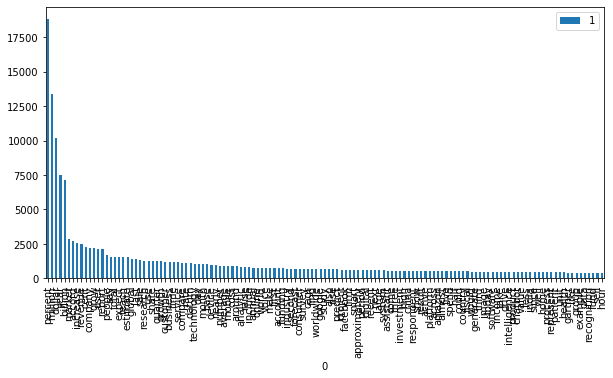

In [72]:
# визуализация наиболее часто встречающихся слов
value_count=400
df1[df1[1]>value_count].plot.bar(x=0,y=1,figsize=(10,5))

8074


<AxesSubplot:xlabel='0'>

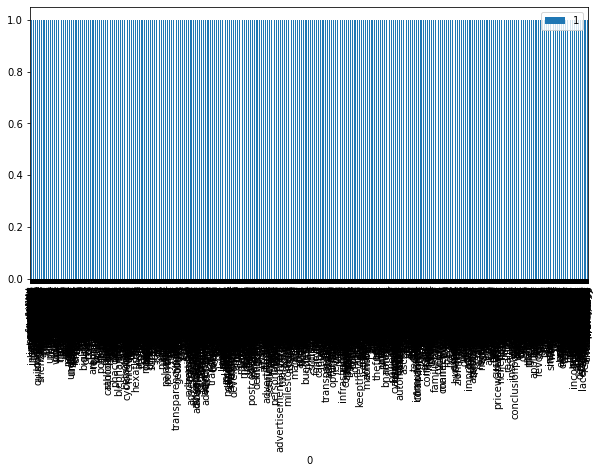

In [73]:
# визуализация наиболее редко встречающихся слов
print(df1[df1[1]<2].shape[0])
df1[df1[1]<2].plot.bar(x=0,y=1,figsize=(10,5))

In [74]:
# генерация мешка слов.
#max_features=1500, сколько термов берем в расчет
#min_df=5, если слово встречается меньшее число раз то игнорируем
#max_df=0.7 верхний порог. если терм встречается в большей доле документов то игнорируем
count_vect = CountVectorizer(max_features=1500, min_df=5, max_df=0.6)
bow = count_vect.fit_transform(df['Clean_sentence'].values)
bow.shape

(25876, 1500)

In [75]:
bow

<25876x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 250873 stored elements in Compressed Sparse Row format>

In [76]:
#print(bow)

In [77]:
# посмотреть какие слова попали в мешок слов
terms = count_vect.get_feature_names()

c:\users\ysiberia\documents\github\market-growth-claims\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [78]:
#first 10 columns generated by BOW
terms[1440:]

['views',
 'virtual',
 'vision',
 'visit',
 'visitors',
 'visits',
 'voice',
 'volume',
 'volumes',
 'wall',
 'want',
 'waste',
 'watch',
 'water',
 'watson',
 'wearable',
 'wearables',
 'website',
 'wechat',
 'wednesday',
 'week',
 'weeks',
 'weight',
 'well',
 'went',
 'whatsapp',
 'whereas',
 'whole',
 'whopping',
 'whose',
 'wide',
 'widely',
 'wind',
 'windows',
 'wireless',
 'within',
 'without',
 'women',
 'word',
 'words',
 'work',
 'workers',
 'workforce',
 'working',
 'works',
 'world',
 'worldwide',
 'worth',
 'would',
 'xiaoice',
 'yahoo',
 'year',
 'years',
 'yes',
 'yet',
 'yield',
 'york',
 'youtube',
 'yuan',
 'zero']

In [79]:
bow

<25876x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 250873 stored elements in Compressed Sparse Row format>

## BERT

In [80]:

from sentence_transformers import SentenceTransformer

In [81]:
# я выбрал семантическое ядро all-MiniLM-L6-v2. По сути на ХаггингФэйс у всех 
#семантических ядер близкие параметры. Это работает быстрее
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [82]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()
corpus_embeddings = embedder.encode(X, show_progress_bar=True, batch_size=1)

Batches:   0%|          | 0/25876 [00:00<?, ?it/s]

In [83]:
corpus_embeddings

array([[ 0.10350126, -0.05597112, -0.04447722, ...,  0.00588111,
         0.0323307 ,  0.00991875],
       [-0.01995114, -0.0312917 , -0.01235101, ..., -0.02538839,
        -0.0086885 , -0.04054197],
       [-0.04839667,  0.04734808, -0.04643425, ..., -0.08693318,
         0.03901883, -0.01164148],
       ...,
       [ 0.06463955,  0.05132082, -0.00159348, ...,  0.05578374,
         0.12403955,  0.0168435 ],
       [ 0.06463955,  0.05132082, -0.00159348, ...,  0.05578374,
         0.12403955,  0.0168435 ],
       [-0.01460637,  0.00626609,  0.05395357, ...,  0.02945799,
         0.06999089, -0.01136441]], dtype=float32)

## Word2Vec  
Векторизация текстов на основе w2v от gensim.

In [84]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()

In [85]:
# 
w2v_model=gensim.models.Word2Vec(X,vector_size=200, 
                                 workers=4,
                                 window=5,# окно контекста
                                   min_count=2)

In [86]:
import numpy as np
sent_vectors = []; # the
for sent in X: # 
    sent_vec = np.zeros(200) # 
    cnt_words =0; # 
    for word in sent: # 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

C:\Users\Ysiberia\AppData\Local\Temp\ipykernel_14648\2526275276.py:13: RuntimeWarning: invalid value encountered in true_divide
  sent_vec /= cnt_words


(25876, 200)

In [87]:
sent_vectors[1]

array([ 5.09194352e-02, -3.59031790e-02, -7.01285298e-02, -5.35170071e-03,
        1.57269997e-02,  3.73623508e-02,  4.00730732e-02,  1.03401103e-02,
        4.86748610e-02,  5.17017808e-02, -1.69036366e-02,  3.64093039e-02,
       -2.56391629e-02, -2.89956076e-02,  4.67017667e-02, -2.11096878e-02,
       -7.58677254e-02,  2.49042492e-02, -3.12441595e-02,  1.41894897e-01,
       -4.16924457e-02, -7.17734211e-02, -7.41690194e-02, -4.85666986e-02,
       -5.93990039e-03, -2.31135122e-02,  4.23422804e-02,  4.94316168e-02,
        5.10021408e-02,  7.86890844e-02, -1.65490668e-02, -4.48523471e-02,
        5.85465270e-02,  5.67568569e-02,  1.27977253e-02,  1.36474957e-02,
       -1.42879500e-02,  1.07239650e-01,  6.57348322e-03,  6.01758118e-02,
       -2.07554901e-02,  2.05022747e-02,  3.26717337e-02,  1.07128266e-02,
       -3.19959608e-02, -5.77689415e-03,  4.65892466e-04,  4.06507559e-02,
        2.57415850e-05,  3.21401835e-02,  5.72562323e-02,  3.52886924e-02,
        2.06558345e-02, -

# Clustering

Кластеризация. Проводится 3 методами (KMeans, DBSCAN, AgglomerativeClustering), для каждого представления эмбедингов(word2vec,tfidf,bert,bag_of_words).  
ТАм где возможно проводится анализ параметров. НО не полным перебором

In [88]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [89]:
import gc

In [90]:
#Далее кластеризация представлена будет примерно по одной схеме:
#Кластеризуем и добавляем лейблы новым столбцом в датасет.  
#Имя столбца - *метод построение эмбедингов*_*алгоритм кластеризации*_*параметры алгоритма*


100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.83s/it]


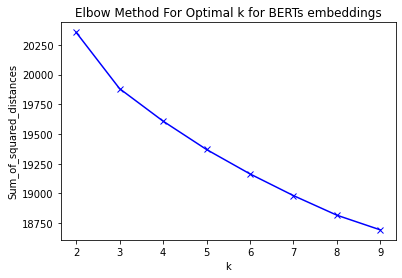

In [91]:
#Для наглядности строится зависимость суммы квадратов расстояний м\у элементом и 
#центром его кластера от количества кластеров.
#Расстояния зависят и от метода построения эмбедингов(разные масштабы)
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(corpus_embeddings)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'Bert_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for BERTs embeddings')
plt.show()

In [92]:
df.to_excel(out_path)

In [93]:
gc.collect()

362451

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.89s/it]


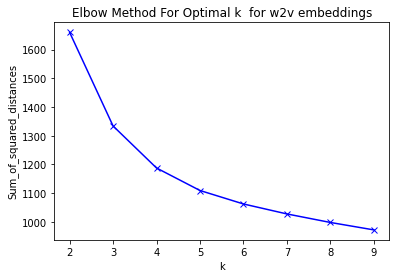

In [94]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(sent_vectors)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'w2v_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k  for w2v embeddings')
plt.show()

In [95]:
df.to_excel(out_path)

In [96]:
gc.collect()

569475

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [04:30<00:00, 33.87s/it]


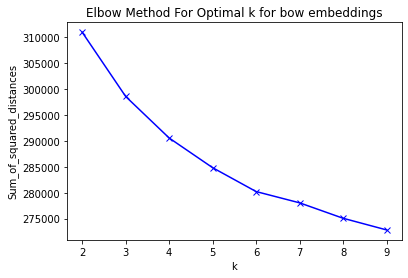

In [97]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(bow)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'bow_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for bow embeddings')
plt.show()


In [98]:
df.to_excel(out_path)

In [99]:
gc.collect()

776499

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [10:26<00:00, 78.37s/it]


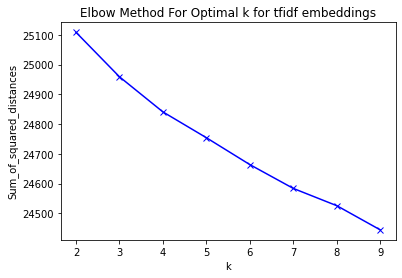

In [100]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X_train_tfidf)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'tfidf_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for tfidf embeddings')
plt.show()

In [101]:
df.to_excel(out_path)

In [102]:
gc.collect()

983523

In [103]:
n_clusters=5

In [104]:
# небольшой пример получения популярных слов в кластерих. монограмы
km = KMeans(n_clusters=n_clusters, max_iter=200, n_init=10)
km = km.fit(corpus_embeddings) #word to vec
Sum_of_squared_distances.append(km.inertia_)

In [105]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 0: abingworth
 abrupt
 abis
 aerogel
 acos
 adroll
 adept
 adipocyte
 accountant
 administration
Cluster 1: abingworth
 advertising
 aerogel
 adipocyte
 adara
 addition
 acos
 accent
 abis
 affected
Cluster 2: adstage
 abingworth
 acsi
 abrh
 abis
 abrupt
 aerogel
 adhd
 acos
 accountant
Cluster 3: abingworth
 abis
 across
 adjust
 adidas
 abrupt
 aerogel
 acquisitionsthe
 adipocyte
 addition
Cluster 4: aerogel
 abingworth
 adipocyte
 adversely
 adjust
 across
 acyl
 accent
 acquisitionsthe
 addition


## DBScan

In [106]:
#Считаю расстояние между minPts близжайшими соседями.
#
minPts = 100 # количество ближайших соседей до которых считаем расстояние
def lower_bound(nums, target): 
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): 
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) 
        if(len(dists) == minPts and dists[minPts-1] > dist): 
            l = int(lower_bound(dists, dist)) 
            if l < minPts and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[minPts-1] 

In [109]:
rows=int(sent_vectors.shape[0]*0.2)
rows

2587

In [110]:
#для каждого объекта считается расстояние от него до 200 близжйших
#потенциально не обязательно 200.
#делается для оптимального выбора параметра eps в DBSCAN. 
#Значение надо брать в меньше чем y где график начинает резко расти
#
twohundrethneigh = []
for val in sent_vectors[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:rows]) ) # rows можно заменитиь на число поменьше
twohundrethneigh.sort()

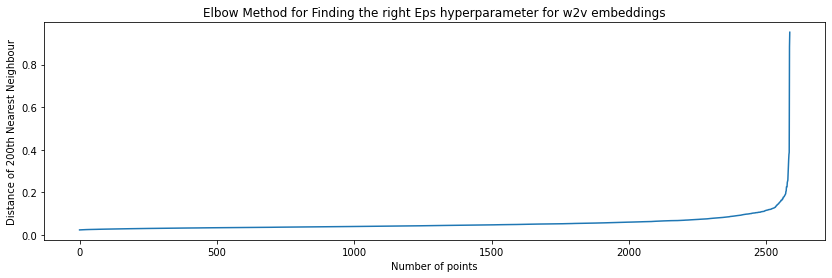

In [111]:
# зависимость расстояния до 200 близжйших соседей от количества учитываемых точек
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for w2v embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [112]:
gc.collect()

3048

In [117]:
# кластеризация и сразу добавление лейблов датафрейм
#neur_ai_classification DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(sent_vectors)
labels = model.labels_
print(set(labels))


{0, -1}


In [118]:
column_name=f'w2v_embed_DBSCAN_0.05_eps'
df[column_name]=labels.tolist()

In [119]:
gc.collect()

120

In [120]:
#neur_ai_classification DBSCAN(eps = 0.2, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.2, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(sent_vectors)
labels = model.labels_
print(set(labels)) # список классов


{0, -1}


In [121]:
column_name=f'w2v_embed_DBSCAN_0.2_eps'
df[column_name]=labels.tolist()

In [122]:
df.to_excel(out_path)

In [123]:
bow_ar= bow.toarray() # из разреженной матрицы в обычный массив для работы алгоритма

In [124]:
twohundrethneigh = []
for val in bow_ar[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, bow_ar[:rows]) )
twohundrethneigh.sort()

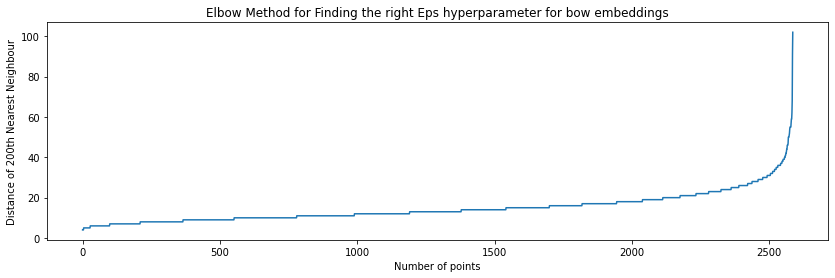

In [125]:
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for bow embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [126]:
gc.collect()

1038219

In [128]:
#neur_ai_classification DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, -1}


In [129]:
column_name=f'bow_embed_DBSCAN_0.5_eps'
df[column_name]=labels.tolist()

In [131]:
#neur_ai_classification DBSCAN(eps = 0.4, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.4, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [132]:
column_name=f'bow_embed_DBSCAN_0.4_eps'
df[column_name]=labels.tolist()

In [133]:
gc.collect()

120

In [134]:
#neur_ai_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [135]:
column_name=f'bow_embed_DBSCAN_0.35_eps'
df[column_name]=labels.tolist()

In [136]:
gc.collect()

120

In [137]:
df.to_excel(out_path)

In [138]:
# Computing the 200th nearest neighbour distance of some point the dataset:
twohundrethneigh = []
for val in corpus_embeddings[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, corpus_embeddings[:rows]) )
twohundrethneigh.sort()

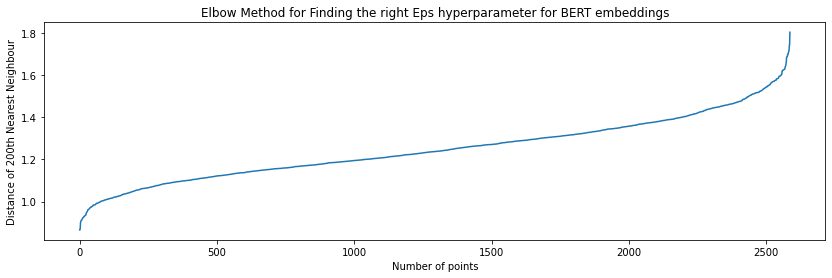

In [139]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for BERT embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [142]:
#neur_ai_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(corpus_embeddings)
labels = model.labels_
print(set(labels))


{0, 1, 2, -1}


In [143]:
column_name=f'BERT_embed_DBSCAN_0.35_eps'
df[column_name]=labels.tolist()

In [144]:
df.to_excel(out_path)

In [145]:
gc.collect()

1138791

In [151]:
#neur_ai_classification DBSCAN(eps = 0.36, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.36, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(corpus_embeddings)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [152]:
column_name=f'BERT_embed_DBSCAN_0.36_eps'
df[column_name]=labels.tolist()

In [153]:
df.to_excel(out_path)

In [154]:
gc.collect()

1164669

In [155]:
X_train_tfidf_arr=X_train_tfidf.toarray()
X_train_tfidf_arr.shape

(25876, 17713)

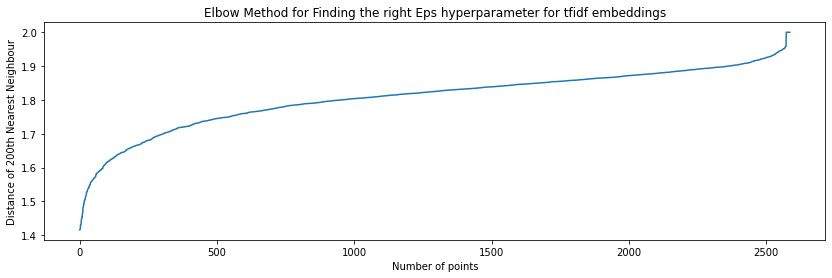

In [156]:

twohundrethneigh = []
for val in X_train_tfidf_arr[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, X_train_tfidf_arr[:rows]) )
twohundrethneigh.sort()
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for tfidf embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [158]:
#neur_ai_classification DBSCAN(eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(X_train_tfidf_arr)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [159]:
column_name=f'tfidf_embed_DBSCAN_0.6_eps'
df[column_name]=labels.tolist()

In [160]:
gc.collect()

3137

In [165]:
#neur_ai_classification DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.5, min_samples = minPts, metric='cosine', n_jobs=-1)
model.fit(X_train_tfidf_arr)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [166]:
column_name=f'tfidf_embed_DBSCAN_0.5_eps'
df[column_name]=labels.tolist()

In [167]:
gc.collect()

1095

## Clustering Hierarchical
работает очень долго!

In [168]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(sent_vectors)
    column_name=f'w2v_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()


100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [04:03<00:00, 81.10s/it]


In [169]:
df.to_excel(out_path)

In [170]:
gc.collect()

1294059

In [171]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(bow_ar)
    column_name=f'bow_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [19:33<00:00, 391.09s/it]


In [172]:
df.to_excel(out_path)

In [173]:
gc.collect()

1371693

In [174]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(corpus_embeddings)
    column_name=f'bert_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [07:22<00:00, 147.42s/it]


In [175]:
df.to_excel(out_path)

In [176]:
gc.collect()

1449327

In [ ]:
# если обратил внимание то на X_train_tfidf_arr вообще все долго работает. А конкретно вот эта ячейка ОЧЕНЬ долго. я предупредил
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(X_train_tfidf_arr)
    column_name=f'tfidf_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()

  0%|                                                                                       | 0/3 [00:00<?, ?it/s]

In [ ]:
df.to_excel(out_path)

In [ ]:
gc.collect()

## Searching best result

In [112]:
df.columns

Index(['sentence', 'Clean_sentence', 'Clean_sentence_lemm_nltk',
       'Clean_sentence_lemm_spacy', 'Bert_embed_K_means_2_clusters',
       'Bert_embed_K_means_3_clusters', 'Bert_embed_K_means_4_clusters',
       'Bert_embed_K_means_5_clusters', 'Bert_embed_K_means_6_clusters',
       'Bert_embed_K_means_7_clusters', 'Bert_embed_K_means_8_clusters',
       'Bert_embed_K_means_9_clusters', 'w2v_embed_K_means_2_clusters',
       'w2v_embed_K_means_3_clusters', 'w2v_embed_K_means_4_clusters',
       'w2v_embed_K_means_5_clusters', 'w2v_embed_K_means_6_clusters',
       'w2v_embed_K_means_7_clusters', 'w2v_embed_K_means_8_clusters',
       'w2v_embed_K_means_9_clusters', 'bow_embed_K_means_2_clusters',
       'bow_embed_K_means_3_clusters', 'bow_embed_K_means_4_clusters',
       'bow_embed_K_means_5_clusters', 'bow_embed_K_means_6_clusters',
       'bow_embed_K_means_7_clusters', 'tfidf_embed_K_means_2_clusters',
       'tfidf_embed_K_means_3_clusters', 'tfidf_embed_K_means_4_clusters',
 

In [114]:
df[][df['Bert_embed_K_means_3_clusters']==0]

sentence  \
8                                                                                                                                                              Do Intel and AMD have upside potential?Intel earns 75% of its revenue from PC and server CPU sales.   
10                                                                    The global digital printing packaging market is estimated to reach $28 billion by 2024, growing at a CAGR of approximately 11% during 2018-2024, cites a recent Research and Markets report.   
12                                                                                     While iPod sales accounted for 40% of Apple's revenue in 2006, according to the data, that figure steadily dropped starting in 2007 following the original iPhone's launch.   
13                                                                                                                                By 2014, the last year Apple broke out iPod sales, the music player had accounted for just 1% of Apple's revenue, says Statista.   
17                                                                                He said his company’s AR revenues are about 7% of the total, and it’s growing about 90 percent a year, thanks to enterprise AR adoption for things like training and field work.   
...                                                                                                                                                                                                                                                            ...   
3493  In 2013, a report commissioned by Google estimated that the value of Geo services is between $150 to $270 billion in revenue annually–in addition to 1.1 billion hours saved per year by keeping people from getting lost or “avoiding wasted journey time.”   
3497                                                                                                           LONDON--( BUSINESS WIRE )-- analysts expect the to exceed USD 31 billion by 2019, growing at a CAGR of almost 8%, according to their latest report.   
3498                                                                                               LONDON--( EON: Enhanced Online News )-- analysts expect the to exceed USD 31 billion by 2019, growing at a CAGR of almost 8%, according to their latest report.   
3514                                                                                                                                               Proof Humility Gets You Growth In a matter of weeks, Ikea Now had over 70,000 users in more than 100 countries.   
3530                                                                                                                                                           Only 13.3% of the phones sold in Q3 of 2009 were smartphones, and of those only 17.1% were iPhones.   

                                                                                                                                                                                 Clean_sentence  \
8                                                                                                                           intel amd upside potential intel earns percent revenue server sales   
10                                              global digital printing packaging market estimated reach dollar billion growing cagr approximately percent cites recent research markets report   
12                                                                  ipod sales accounted percent apple revenue according data figure steadily dropped starting following original iphone launch   
13                                                                                                  last year apple broke ipod sales music player accounted percent apple revenue says statista   
17                                                                          said company revenues percent total growing percent ye

## Search n-grams

In [122]:
def search_ngrams(data:list, n_size:int):
    n_grams_counter={}
    for sentence in data:
        sentence=sentence.split(' ')
        for word in range(len(sentence)-n_size+1):
            n_gramma=sentence[word:word+n_size]
            n_gramma=' '.join([w for w in n_gramma])
            if n_gramma in n_grams_counter.keys():
                n_grams_counter[n_gramma]+=1
            else:
                n_grams_counter[n_gramma]=1
    return n_grams_counter

In [123]:
X

['charge unlike anything see reach full percent minute',
 'percent people visit online casino play slot',
 'total gallon water float soak splash around square foot expand pool deck area feature cabana lounge daybed booth',
 'headset shipment decline cent million unit million unit',
 'essentially cent original vive headset',
 'support monthly player base roughly million people league popular esports scene world',
 'found company land roughly dollar million investment fund samsung next mark pincus kakao venture other',
 'course promotion frito expect distribute million chip bag',
 'intel amd upside potential intel earn percent revenue server sale',
 'neural engine billion operation second apple make eight time fast trillion operation second',
 'global digital printing packaging market estimate reach dollar billion grow cagr approximately percent cite recent research market report',
 'automation vendor claim plant output downtime reduction much percent domino effect uptick throughput byas

In [124]:
bigrams=search_ngrams(X,2)

In [125]:
bigrams_tuples = sorted(bigrams.items(), key=lambda item: item[1],reverse=True)
print(bigrams_tuples)  # [(1, 1), (3, 4), (2, 9)]

[('dollar million', 949), ('dollar billion', 764), ('million unit', 210), ('last year', 187), ('million dollar', 159), ('virtual reality', 139), ('percent year', 125), ('cagr percent', 125), ('reach million', 114), ('percent percent', 112), ('billion dollar', 111), ('reach dollar', 105), ('year year', 102), ('million people', 91), ('increase percent', 86), ('raise dollar', 84), ('second quarter', 77), ('expect grow', 77), ('sell million', 75), ('augment reality', 71), ('million million', 69), ('million year', 68), ('grow dollar', 67), ('grow percent', 67), ('annual growth', 65), ('percent total', 63), ('compound annual', 59), ('year ago', 59), ('growth rate', 58), ('market expect', 58), ('percent dollar', 58), ('fourth quarter', 57), ('third quarter', 55), ('grow million', 53), ('generate dollar', 53), ('income dollar', 53), ('grow cagr', 52), ('million user', 52), ('account percent', 51), ('billion revenue', 51), ('research firm', 48), ('first quarter', 48), ('compare dollar', 47), ('

In [132]:
len(threrams_tuples)+len(fourgrams_tuples)

58748

In [133]:
len(bigrams_tuples)+len(threrams_tuples)+len(fourgrams_tuples)+len(fivegrams_tuples)

110577

In [127]:
threrams=search_ngrams(X,3)

In [128]:
threrams_tuples = sorted(threrams.items(), key=lambda item: item[1],reverse=True)
print(threrams_tuples)  # [(1, 1), (3, 4), (2, 9)]

[('dollar million dollar', 136), ('dollar billion dollar', 90), ('million dollar million', 87), ('billion dollar billion', 86), ('raise dollar million', 81), ('reach dollar billion', 80), ('percent year year', 69), ('compound annual growth', 58), ('annual growth rate', 56), ('income dollar million', 50), ('grow dollar billion', 49), ('dollar billion revenue', 47), ('quarter last year', 45), ('dollar dilute share', 45), ('million dollar dilute', 43), ('grow cagr percent', 42), ('reach million unit', 40), ('compare dollar million', 40), ('quarter dollar million', 40), ('loss dollar million', 38), ('dollar million year', 37), ('dollar million compare', 36), ('dollar million funding', 33), ('total dollar million', 33), ('head mount display', 32), ('virtual reality headset', 31), ('growth rate cagr', 31), ('generate dollar billion', 31), ('revenue dollar billion', 30), ('percent dollar billion', 30), ('market expect grow', 29), ('dollar billion year', 29), ('dollar million revenue', 27), ('

In [129]:
fourgrams=search_ngrams(X,4)
fourgrams_tuples = sorted(fourgrams.items(), key=lambda item: item[1],reverse=True)
print(fourgrams_tuples)  # [(1, 1), (3, 4), (2, 9)]

[('dollar billion dollar billion', 76), ('dollar million dollar million', 71), ('compound annual growth rate', 54), ('dollar million dollar dilute', 43), ('million dollar dilute share', 43), ('annual growth rate cagr', 31), ('growth rate cagr percent', 26), ('cagr percent forecast period', 20), ('income dollar million dollar', 20), ('grow dollar billion dollar', 19), ('dollar million second quarter', 19), ('dollar million year ago', 19), ('augment reality virtual reality', 18), ('expect grow dollar billion', 18), ('dollar million increase percent', 18), ('dollar dilute share compare', 17), ('annual growth rate percent', 16), ('expect reach dollar billion', 15), ('percent gross profit dollar', 15), ('gross profit dollar million', 15), ('second quarter last year', 15), ('percent compare dollar million', 15), ('gaap income dollar million', 15), ('dollar million prior quarter', 15), ('operate income dollar million', 14), ('quarter dollar million dollar', 14), ('dollar million dollar billio

In [130]:
fivegrams=search_ngrams(X,5)
fivegrams_tuples = sorted(fivegrams.items(), key=lambda item: item[1],reverse=True)
print(fivegrams_tuples)  # [(1, 1), (3, 4), (2, 9)]

[('dollar million dollar dilute share', 43), ('compound annual growth rate cagr', 31), ('annual growth rate cagr percent', 26), ('grow dollar billion dollar billion', 19), ('income dollar million dollar dilute', 18), ('compound annual growth rate percent', 16), ('million dollar dilute share compare', 16), ('gaap income dollar million dollar', 14), ('percent gross profit dollar million', 13), ('share compare gaap income dollar', 12), ('compare gaap income dollar million', 12), ('market expect grow cagr percent', 10), ('approximately percent total cellular connection', 10), ('operating income dollar million compare', 10), ('decrease dollar million dollar million', 10), ('dollar million cash cash equivalent', 10), ('quarter dollar million dollar dilute', 10), ('dollar dilute share compare gaap', 10), ('dilute share compare gaap income', 10), ('dollar million increase percent compare', 10), ('million increase percent compare dollar', 10), ('increase percent compare dollar million', 10), ('